# Ensemble Voting Model — Don't Patronize Me!

**Binary PCL classification** using RoBERTa, DistilBERT, and MPNet with majority-vote ensemble.

## 1. Imports

In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from scipy.special import softmax as scipy_softmax
import matplotlib.pyplot as plt
import gc
import glob, os

print(f"PyTorch version : {torch.__version__}")
print(f"CUDA available  : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device      : {torch.cuda.get_device_name(0)}")
    print(f"GPU memory      : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

/home/azureuser/nlp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version : 2.10.0+cu128
CUDA available  : True
GPU device      : Tesla T4
GPU memory      : 15.6 GB


## 2. Device Setup

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_LABELS = 2
LABEL_NAMES = ["Non-PCL", "PCL"]

# Class weights for the ~9.5:1 imbalance (Non-PCL : PCL)
CLASS_WEIGHTS = torch.tensor([1.0, 9.0], dtype=torch.float32).to(DEVICE)

print(f"Using device    : {DEVICE}")
print(f"Class weights   : {CLASS_WEIGHTS}  (device: {CLASS_WEIGHTS.device})")

Using device    : cuda
Class weights   : tensor([1., 9.], device='cuda:0')  (device: cuda:0)


## 3. Load & Preprocess Dataset

Binary labels as per the paper: labels 0-1 → **Non-PCL (0)**, labels 2-4 → **PCL (1)**.

We split 80/10/10 into train / val / test. The test set is held out entirely until final evaluation.

In [3]:
def load_data():
    """Load Don't Patronize Me PCL dataset and binarise labels."""
    pcl_columns = ["par_id", "art_id", "keyword", "country_code", "text", "label"]
    df = pd.read_csv(
        "dontpatronizeme_pcl.tsv",
        sep="\t",
        skiprows=4,
        names=pcl_columns,
        on_bad_lines="skip",
        engine="python",
    )

    # Drop rows with missing text or labels
    df = df.dropna(subset=["text", "label"])
    df["label"] = df["label"].astype(int)

    # Binary: 0-1 → Non-PCL (0),  2-4 → PCL (1)
    df["binary_label"] = (df["label"] >= 2).astype(int)

    print(f"Total samples  : {len(df)}")
    print(f"Label distribution:\n{df['binary_label'].value_counts().rename({0: 'Non-PCL', 1: 'PCL'})}")
    print(f"Imbalance ratio: {(df['binary_label'] == 0).sum() / (df['binary_label'] == 1).sum():.2f}:1")

    return df


df = load_data()

# 80 / 10 / 10 stratified split
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["binary_label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["binary_label"], random_state=42
)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_dict({"text": train_df["text"].tolist(), "label": train_df["binary_label"].tolist()})
val_dataset   = Dataset.from_dict({"text": val_df["text"].tolist(),   "label": val_df["binary_label"].tolist()})
test_dataset  = Dataset.from_dict({"text": test_df["text"].tolist(),  "label": test_df["binary_label"].tolist()})

print(f"\nSplit sizes — train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")

Total samples  : 10468
Label distribution:
binary_label
Non-PCL    9475
PCL         993
Name: count, dtype: int64
Imbalance ratio: 9.54:1

Split sizes — train: 8374, val: 1047, test: 1047


## 4. Model Definitions & Tokenisation

We define:
- **Model catalogue** — three transformer architectures
- **`WeightedTrainer`** — custom Trainer that uses class-weighted CrossEntropyLoss. The class weights tensor is moved to device **once** (at init), not on every forward pass.
- **`compute_metrics`** — accuracy, precision, recall, F1
- Per-model tokenisation functions

In [4]:
MODEL_CATALOGUE = {
    "RoBERTa":    "FacebookAI/roberta-base",
    "DistilBERT": "distilbert-base-uncased",
    "MPNet":      "microsoft/mpnet-base",
}

MAX_LENGTH = 128  # EDA: median 42 word tokens, 95th pct ~105; subword inflation ~1.3x → 128 is safe


class WeightedTrainer(Trainer):
    """Trainer that applies class weights to CrossEntropyLoss."""

    def __init__(self, class_weights: torch.Tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        weights = self._class_weights.to(dtype=logits.dtype, device=logits.device)
        loss_fn = nn.CrossEntropyLoss(weight=weights, reduction="mean")
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, F1 for the positive class (PCL)."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1, zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


# Load tokenisers (dynamic padding via DataCollatorWithPadding)
tokenisers = {}
for name, path in MODEL_CATALOGUE.items():
    tokenisers[name] = AutoTokenizer.from_pretrained(path)
    print(f"Loaded tokeniser for {name}")


def tokenize_dataset(dataset, tokenizer):
    """Tokenise a HuggingFace Dataset with the given tokenizer (no padding)."""
    def _tok(examples):
        return tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTH)
    return dataset.map(_tok, batched=True)

Loaded tokeniser for RoBERTa
Loaded tokeniser for DistilBERT


Loaded tokeniser for MPNet


## 5. Hyperparameters

**Fixed hyperparameters** based on prior tuning and literature recommendations for transformer fine-tuning on imbalanced binary classification:

- **Learning rate**: 2e-5 (standard BERT fine-tuning rate)
- **Epochs**: 4 (sufficient for convergence without overfitting)
- **Batch size**: 32 (fits comfortably on most GPUs)  
- **Weight decay**: 0.06 (mild regularisation)
- **Class weight (PCL)**: 8.5 (compensates for 9.5:1 class imbalance)

In [ ]:
# Fixed hyperparameters (no search required)
HYPERPARAMS = {
    "learning_rate": 2e-5,
    "num_train_epochs": 4,
    "batch_size": 32,
    "weight_decay": 0.06,
}

# ── Training toggle ──────────────────────────────────────────────────────────
# True  = train from scratch and save a new checkpoint
# False = skip training, reload the model from the existing checkpoint
TRAIN_TOGGLE = {
    "RoBERTa":    False,
    "DistilBERT": True,
    "MPNet":      False,
}

print("Hyperparameters:")
for k, v in HYPERPARAMS.items():
    print(f"  {k}: {v}")
print(f"\nTraining toggles: {TRAIN_TOGGLE}")

Hyperparameters:
  learning_rate: 2e-05
  num_train_epochs: 4
  batch_size: 32
  weight_decay: 0.06

Training toggles: {'RoBERTa': False, 'DistilBERT': True, 'MPNet': False}
Ensemble weights: {'RoBERTa': 1.1, 'DistilBERT': 0.9, 'MPNet': 1.0}
Ensemble threshold (weighted sum > 1.5)


## 6. Train / Reload Each Model

If `TRAIN_TOGGLE[model]` is **True**, train from scratch and save a new checkpoint.  
If **False**, reload the best checkpoint from `<model>_final/checkpoint-*`.

In [11]:
trained_models = {}
trainers = {}

for name, model_path in MODEL_CATALOGUE.items():
    print(f"\n{'='*60}")

    tokenizer = tokenisers[name]
    train_tok = tokenize_dataset(train_dataset, tokenizer)
    val_tok = tokenize_dataset(val_dataset, tokenizer)

    output_dir = f"./results/{name}_final"

    # ── Decide: train or reload ──────────────────────────────────────────
    if TRAIN_TOGGLE.get(name, True):
        print(f"  Training: {name}  (TRAIN_TOGGLE = True)")
        print(f"{'='*60}")

        model = AutoModelForSequenceClassification.from_pretrained(
            model_path, num_labels=NUM_LABELS
        )

        use_fp16, use_bf16 = False, False
        print(f"  Mixed precision — fp16: {use_fp16}, bf16: {use_bf16}")

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=HYPERPARAMS["num_train_epochs"],
            per_device_train_batch_size=HYPERPARAMS["batch_size"],
            per_device_eval_batch_size=HYPERPARAMS["batch_size"],
            learning_rate=HYPERPARAMS["learning_rate"],
            weight_decay=HYPERPARAMS["weight_decay"],
            eval_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            logging_steps=50,
            fp16=use_fp16,
            bf16=use_bf16,
            warmup_ratio=0.1,
            max_grad_norm=1.0,
            dataloader_num_workers=2,
            report_to="none",
        )

        trainer = WeightedTrainer(
            class_weights=CLASS_WEIGHTS,
            model=model,
            args=training_args,
            train_dataset=train_tok,
            eval_dataset=val_tok,
            compute_metrics=compute_metrics,
            processing_class=tokenizer,
            data_collator=DataCollatorWithPadding(tokenizer),
        )

        trainer.train()
        print(f"✓ {name} training complete.")

    else:
        # ── Reload from saved checkpoint ─────────────────────────────────
        ckpt_dirs = sorted(glob.glob(os.path.join(output_dir, "checkpoint-*")))
        if not ckpt_dirs:
            raise FileNotFoundError(
                f"No checkpoint found under {output_dir}. "
                f"Set TRAIN_TOGGLE['{name}'] = True to train first."
            )
        ckpt_path = ckpt_dirs[-1]  # latest checkpoint
        print(f"  Reloading: {name}  (TRAIN_TOGGLE = False)")
        print(f"  Checkpoint: {ckpt_path}")
        print(f"{'='*60}")

        model = AutoModelForSequenceClassification.from_pretrained(
            ckpt_path, num_labels=NUM_LABELS
        )

        training_args = TrainingArguments(
            output_dir=output_dir,
            per_device_eval_batch_size=HYPERPARAMS["batch_size"],
            report_to="none",
        )

        trainer = WeightedTrainer(
            class_weights=CLASS_WEIGHTS,
            model=model,
            args=training_args,
            eval_dataset=val_tok,
            compute_metrics=compute_metrics,
            processing_class=tokenizer,
            data_collator=DataCollatorWithPadding(tokenizer),
        )

        print(f"✓ {name} loaded from checkpoint.")

    trained_models[name] = model
    trainers[name] = trainer

    # Free GPU memory between models
    torch.cuda.empty_cache()
    gc.collect()

Map: 100%|██████████| 1047/1047 [00:00<00:00, 16536.20 examples/s]


  Reloading: RoBERTa  (TRAIN_TOGGLE = False)
  Checkpoint: ./results/RoBERTa_final/checkpoint-1048


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 951.13it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


✓ RoBERTa loaded from checkpoint.



Map: 100%|██████████| 1047/1047 [00:00<00:00, 13931.65 examples/s]


  Training: DistilBERT  (TRAIN_TOGGLE = True)


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 990.77it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


  Mixed precision — fp16: False, bf16: False


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.462931,0.440118,0.802292,0.299625,0.800000,0.435967
2,0.355362,0.402984,0.829035,0.336100,0.810000,0.475073
3,0.248080,0.511433,0.898758,0.477941,0.650000,0.550847
4,0.152319,0.590358,0.900669,0.484848,0.640000,0.551724


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


✓ DistilBERT training complete.



Map: 100%|██████████| 1047/1047 [00:00<00:00, 15720.81 examples/s]


  Reloading: MPNet  (TRAIN_TOGGLE = False)
  Checkpoint: ./results/MPNet_final/checkpoint-786


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 935.03it/s, Materializing param=mpnet.encoder.relative_attention_bias.weight]     


✓ MPNet loaded from checkpoint.


## 7. Per-Model Evaluation — Results & Confusion Matrices

Evaluate each model individually on the **test set**, print classification reports, and plot confusion matrices.


  Test Evaluation: RoBERTa


Map: 100%|██████████| 1047/1047 [00:00<00:00, 16941.16 examples/s]



RoBERTa — Classification Report:
              precision    recall  f1-score   support

     Non-PCL     0.9672    0.9335    0.9501       948
         PCL     0.5227    0.6970    0.5974        99

    accuracy                         0.9112      1047
   macro avg     0.7450    0.8153    0.7737      1047
weighted avg     0.9252    0.9112    0.9167      1047



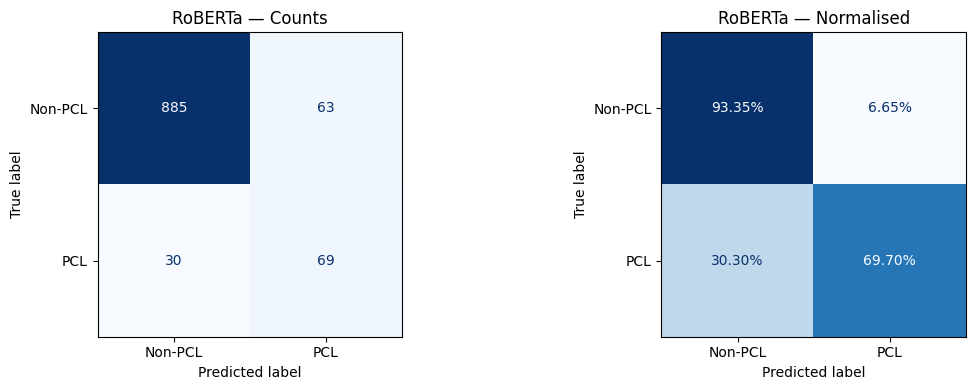


  Test Evaluation: DistilBERT


Map: 100%|██████████| 1047/1047 [00:00<00:00, 13549.47 examples/s]



DistilBERT — Classification Report:
              precision    recall  f1-score   support

     Non-PCL     0.9582    0.9198    0.9386       948
         PCL     0.4453    0.6162    0.5169        99

    accuracy                         0.8911      1047
   macro avg     0.7017    0.7680    0.7278      1047
weighted avg     0.9097    0.8911    0.8988      1047



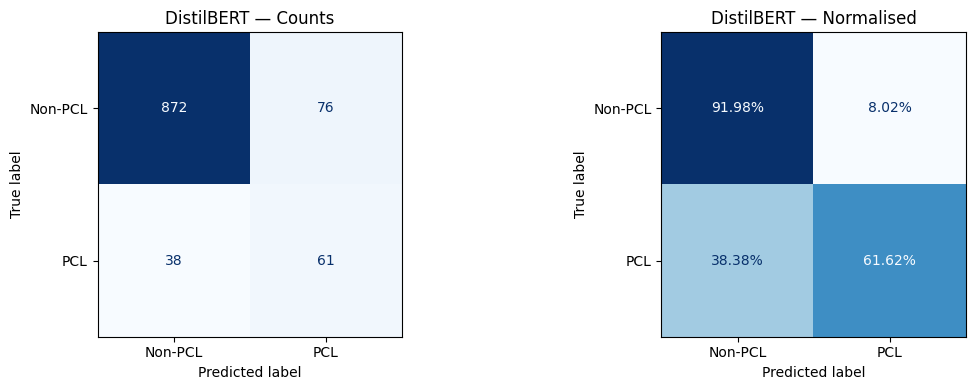


  Test Evaluation: MPNet


Map: 100%|██████████| 1047/1047 [00:00<00:00, 14235.63 examples/s]



MPNet — Classification Report:
              precision    recall  f1-score   support

     Non-PCL     0.9579    0.9357    0.9466       948
         PCL     0.4959    0.6061    0.5455        99

    accuracy                         0.9045      1047
   macro avg     0.7269    0.7709    0.7460      1047
weighted avg     0.9142    0.9045    0.9087      1047



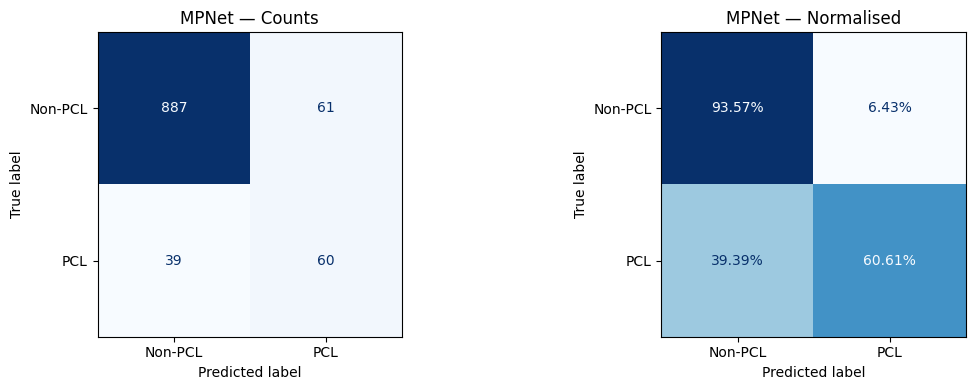

In [ ]:
per_model_preds = {}   # {name: np.array of hard predictions on test set}
per_model_probs = {}   # {name: np.array of PCL (class-1) probabilities}

for name in MODEL_CATALOGUE:
    print(f"\n{'='*60}")
    print(f"  Test Evaluation: {name}")
    print(f"{'='*60}")

    tokenizer = tokenisers[name]
    test_tok = tokenize_dataset(test_dataset, tokenizer)
    trainer = trainers[name]

    # Predict on test set
    predictions = trainer.predict(test_tok)
    logits = predictions.predictions                    # (n, 2)
    probs  = scipy_softmax(logits, axis=-1)             # softmax → probabilities
    preds  = np.argmax(logits, axis=-1)
    labels = predictions.label_ids

    per_model_preds[name] = preds
    per_model_probs[name] = probs[:, 1]                 # P(PCL)

    # Classification report
    print(f"\n{name} — Classification Report:")
    print(classification_report(labels, preds, target_names=LABEL_NAMES, digits=4))

    # Confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    cm = confusion_matrix(labels, preds)
    ConfusionMatrixDisplay(cm, display_labels=LABEL_NAMES).plot(
        ax=axes[0], cmap="Blues", colorbar=False
    )
    axes[0].set_title(f"{name} — Counts")

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    ConfusionMatrixDisplay(cm_norm, display_labels=LABEL_NAMES).plot(
        ax=axes[1], cmap="Blues", colorbar=False, values_format=".2%"
    )
    axes[1].set_title(f"{name} — Normalised")

    plt.tight_layout()
    plt.show()

## 8. Overall Ensemble — Weighted Soft Vote, Results & Confusion Matrix

Each model produces a PCL probability via softmax. The **weighted sum** of these probabilities is compared against `ENSEMBLE_THRESHOLD` (default 1.5, i.e. average probability > 50% when all weights = 1).

  ENSEMBLE (Weighted Soft Vote) — Test Set Results
  Weights    : {'RoBERTa': 1.3, 'DistilBERT': 0.8, 'MPNet': 0.9}
  Threshold  : weighted_sum > 1.38  (avg > 0.4600)
              precision    recall  f1-score   support

     Non-PCL     0.9662    0.9335    0.9496       948
         PCL     0.5191    0.6869    0.5913        99

    accuracy                         0.9102      1047
   macro avg     0.7426    0.8102    0.7704      1047
weighted avg     0.9239    0.9102    0.9157      1047


Summary comparison:


,Accuracy,Precision,Recall,F1
Model,,,,
RoBERTa,0.9112,0.5227,0.6970,0.5974
DistilBERT,0.8911,0.4453,0.6162,0.5169
MPNet,0.9045,0.4959,0.6061,0.5455
ENSEMBLE (soft),0.9102,0.5191,0.6869,0.5913


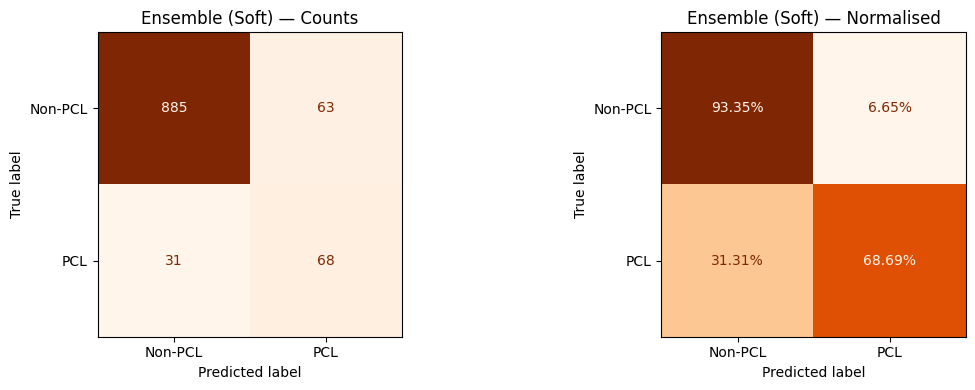


Ensemble score statistics (weighted_sum / 3):
  min=0.0174  max=0.9839  mean=0.1463  median=0.0240
  Samples predicted PCL: 131 / 1047


In [29]:
# Weighted soft vote: sum of  w_i * P(PCL)_i  vs threshold
# ── Ensemble configuration ───────────────────────────────────────────────────
# Weights applied to each model's PCL probability in the soft vote.
ENSEMBLE_WEIGHTS = {
    "RoBERTa":    1.3,
    "DistilBERT": 0.8,
    "MPNet":      0.9,
}
# Threshold on the *weighted sum* of PCL probabilities.
# With all weights = 1.0 and 3 models, max weighted sum = 3.0.
# A threshold of 1.5 means the average model must assign > 50% PCL probability.
ENSEMBLE_THRESHOLD = 1.38

weighted_sum = np.zeros(len(test_dataset))
for name in MODEL_CATALOGUE:
    w = ENSEMBLE_WEIGHTS[name]
    weighted_sum += w * per_model_probs[name]

ensemble_score = weighted_sum / 3  # average weighted probability
ensemble_preds = (ensemble_score > (ENSEMBLE_THRESHOLD / 3)).astype(int)
true_labels = np.array(test_dataset["label"])

# ---------------------------------------------------------------------------
# Overall classification report
# ---------------------------------------------------------------------------
print("=" * 60)
print("  ENSEMBLE (Weighted Soft Vote) — Test Set Results")
print("=" * 60)
print(f"  Weights    : {ENSEMBLE_WEIGHTS}")
print(f"  Threshold  : weighted_sum > {ENSEMBLE_THRESHOLD}  (avg > {ENSEMBLE_THRESHOLD/3:.4f})")
print(classification_report(true_labels, ensemble_preds, target_names=LABEL_NAMES, digits=4))

# Per-model vs ensemble summary table
rows = []
for name, preds in per_model_preds.items():
    p, r, f1, _ = precision_recall_fscore_support(true_labels, preds, average="binary", pos_label=1)
    acc = accuracy_score(true_labels, preds)
    rows.append({"Model": name, "Accuracy": acc, "Precision": p, "Recall": r, "F1": f1})

p, r, f1, _ = precision_recall_fscore_support(true_labels, ensemble_preds, average="binary", pos_label=1)
acc = accuracy_score(true_labels, ensemble_preds)
rows.append({"Model": "ENSEMBLE (soft)", "Accuracy": acc, "Precision": p, "Recall": r, "F1": f1})

summary_df = pd.DataFrame(rows).set_index("Model")
print("\nSummary comparison:")
display(summary_df.style.format("{:.4f}").highlight_max(axis=0, color="lightgreen"))

# ---------------------------------------------------------------------------
# Confusion matrices — ensemble
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm = confusion_matrix(true_labels, ensemble_preds)
ConfusionMatrixDisplay(cm, display_labels=LABEL_NAMES).plot(
    ax=axes[0], cmap="Oranges", colorbar=False
)
axes[0].set_title("Ensemble (Soft) — Counts")

cm_norm = confusion_matrix(true_labels, ensemble_preds, normalize="true")
ConfusionMatrixDisplay(cm_norm, display_labels=LABEL_NAMES).plot(
    ax=axes[1], cmap="Oranges", colorbar=False, values_format=".2%"
)
axes[1].set_title("Ensemble (Soft) — Normalised")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Probability distribution of ensemble scores
# ---------------------------------------------------------------------------
print(f"\nEnsemble score statistics (weighted_sum / 3):")
print(f"  min={ensemble_score.min():.4f}  max={ensemble_score.max():.4f}  "
      f"mean={ensemble_score.mean():.4f}  median={np.median(ensemble_score):.4f}")
print(f"  Samples predicted PCL: {ensemble_preds.sum()} / {len(ensemble_preds)}")